# Part 1: Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os 

# Part 2: Process data

In [25]:
evaluation_results_path = 'evaluation_results.json'
with open(evaluation_results_path, 'r') as f:
            data = pd.read_json(f)

images_dir = 'images'   

# Remove all columns except Model_id, Extractive_model, Abstractive_model, Ratio_mode and Evaluation_metrics

data = data[['Model_ID', 'Extractive_model', 'Abstractive_model', 'Ratio_mode', 'Evaluation_metrics']]

# Unpack Evaluation_metrics into separate columns, one for each metric, currently they are in a dictionary
data = pd.concat([data.drop(['Evaluation_metrics'], axis=1), data['Evaluation_metrics'].apply(pd.Series)], axis=1)

# Remove the BART_no_extraction_V1 model as it is not relevant for the evaluation
data = data[data['Model_ID'] != 'BART_no_extraction_V1']
#data = data[data['Model_ID'] != 'BART_no_extraction_V2']

# Add a column which contains a boolean value indicating if the model is a legal model or not 
data['Legal_model'] = data['Model_ID'].apply(lambda x: 'Legal LM' if 'Legal' in x or 'Lex' in x else 'General LM')

# Add a column which adds the extractive model context length
context_lengths ={
        'RoBERTa': 512,
        'LegalBERT': 512,
        'LexLM': 512,
        'Longformer': 4096,
        'LexLM_Longformer': 4096,
        'BART': 1024,
        'T5': 512,
        'LongT5': 16384,
        'Pegasus': 1024,
        'PegasusX': 16384,
        'LLama3': 8192,
        'Mixtral': 32768,
        'No extractive model': None
}

data['Context_length_extractive'] = data['Extractive_model'].apply(lambda x: context_lengths[x])
data['Context_length_abstractive'] = data['Abstractive_model'].apply(lambda x: context_lengths[x])

# Split data to be used for extractive research (i.e. chapter 4.1 - 4.3)
extractive_research_data = data.iloc[:16]
bart_baseline = data[data['Model_ID'] == 'BART_no_extraction_V2']
abstractive_research_data = data.iloc[16:]
abstractive_research_data = abstractive_research_data.append(bart_baseline)
# Reset the index if desired
abstractive_research_data.reset_index(drop=True, inplace=True)


                              Model_ID     Extractive_model Abstractive_model  \
1               RoBERTa_BART_hybrid_V1              RoBERTa              BART   
2                RoBERTa_BART_fixed_V1              RoBERTa              BART   
3            RoBERTa_BART_dependent_V1              RoBERTa              BART   
4                BART_no_extraction_V2              RoBERTa              BART   
5          LegalBERT_BART_dependent_V1            LegalBERT              BART   
6              LegalBERT_BART_fixed_V1            LegalBERT              BART   
7             LegalBERT_BART_hybrid_V1            LegalBERT              BART   
8                  LexLM_BART_fixed_V1                LexLM              BART   
9              LexLM_BART_dependent_V1                LexLM              BART   
10                LexLM_BART_hybrid_V1                LexLM              BART   
11      LexLM_Longformer_BART_fixed_V1     LexLM_Longformer              BART   
12  LexLM_Longformer_BART_de

/var/folders/d4/csgbs8kx47vg354l4c66hmvh0000gn/T/ipykernel_60625/3814533265.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  abstractive_research_data = abstractive_research_data.append(bart_baseline)


# Part 3: Data analysis

In [3]:
#TODO: Create a function that takes in data (Ratio_data, Legal_data etc.) and metric and creates a plot for it.
def create_one_big_plot(data, comparison_type):
    """
    Create a big plot with multiple subplots to visualize various metrics.

    Parameters:
    - data (pandas.DataFrame): The data containing the metrics to be plotted.
    - comparison_type (str): The type of comparison for the metrics.

    Returns:
    None
    """

    # Extract metrics
    rouge_1 = data['ROUGE-1'].values
    rouge_2 = data['ROUGE-2'].values
    rouge_l = data['ROUGE-L'].values
    bertscore = data['BERTScore'].values
    bartscore = data['BARTScore'].values
    blanc = data['BLANC'].values

    # Create subplots
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    bar_labels = data.index

    if bar_labels.dtype == 'object':
        bar_labels = [x.capitalize().replace('lm', 'LM') if 'lm' in x.capitalize() else x.capitalize() for x in bar_labels]
    x = np.arange(len(bar_labels))  # the label locations
    width = 0.25  # the width of the bars

    # Plot ROUGE metrics
    axs[0, 0].bar(x - width, rouge_1, width, label='ROUGE-1')
    axs[0, 0].bar(x, rouge_2, width, label='ROUGE-2')
    axs[0, 0].bar(x + width, rouge_l, width, label='ROUGE-L')
    axs[0, 0].set_ylabel('Scores')
    axs[0, 0].set_title(f'ROUGE scores by {comparison_type}')
    axs[0, 0].set_xticks(x)
    axs[0, 0].set_xticklabels(bar_labels)
    axs[0, 0].legend()
    axs[0, 0].set_ylim(0, 1)

    # Plot BertScore
    axs[0, 1].bar(x, bertscore, width *2)
    axs[0, 1].set_ylabel('BERTScore')
    axs[0, 1].set_title(f'BERTScore by {comparison_type}')
    axs[0, 1].set_xticks(x)
    axs[0, 1].set_xticklabels(bar_labels)
    axs[0, 1].set_ylim(0, 1)

    # Plot BARTScore
    axs[1, 0].bar(x, bartscore, width*2)
    axs[1, 0].set_ylabel('BARTScore')
    axs[1, 0].set_title(f'BARTScore by {comparison_type}')
    axs[1, 0].set_xticks(x)
    axs[1, 0].set_xticklabels(bar_labels)
    axs[1, 0].set_ylim(-5, 5)

    # Plot BLANC
    axs[1, 1].bar(x, blanc, width*2)
    axs[1, 1].set_ylabel('BLANC score')
    axs[1, 1].set_title(f'BLANC score by {comparison_type}')
    axs[1, 1].set_xticks(x)
    axs[1, 1].set_xticklabels(bar_labels)
    axs[1, 1].set_ylim(0, 1)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    comparison_type = comparison_type.replace(' ', '_')
    plt.savefig(os.path.join(images_dir, f'metrics_by_{comparison_type}.png'))
    plt.show()


def create_latex_string(data, caption):
    """
    Create a LaTeX string representation of a pandas DataFrame.

    Args:
        data (pandas.DataFrame): The DataFrame to convert to LaTeX.
        caption (str): The caption to include in the LaTeX output.

    Returns:
        str: The LaTeX string representation of the DataFrame.

    Example:
        >>> df = pd.DataFrame({'A': [1, 2, 3], 'B': [4, 5, 6]})
        >>> create_latex_string(df, 'Example DataFrame')
        '\\begin{tabular}{lcccccc}\n\\toprule\n A & B \\\\\n\\midrule\n 1 & 4 \\\\\n 2 & 5 \\\\\n 3 & 6 \\\\\n\\bottomrule\n\\end{tabular}\n\\caption{Example DataFrame}\n\\label{tab: Example DataFrame}'
    """
    column_format = 'l' + 'c' * (data.shape[1] - 1)
    if caption == 'extractive context length':
        column_format = 'c' + 'c' * (data.shape[1] - 1)
    
    latex_string = data.to_latex(index=False, float_format='%.4f', column_format= column_format, position='!h')

    # Modify the LaTeX string to place the caption and label after the tabular environment
    latex_string = latex_string.replace('\\end{tabular}', '\\end{tabular}\n\\caption{' + caption + '}\n\\label{tab: ' + caption + '}')

    return latex_string


## 3.1: Ratio types

### 3.1.1: Further process dataset and print latex

In [4]:
#Average results for models that have the same ratio_mode. 
# So combine the evaluation results for models that have the same ratio_mode and calculate the average for each metric.
ratio_data = extractive_research_data.groupby(['Ratio_mode']).mean()
ratio_data = ratio_data.drop(['Context_length_extractive', 'Context_length_abstractive'], axis=1)

# Create a copy of ratio_data with the index renamed
ratio_data_copy = ratio_data.rename_axis('Ratio mode').reset_index()
ratio_data_copy['Ratio mode'] = ratio_data_copy['Ratio mode'].str.capitalize()

# Reorder the rows as Fixed, Dependent, Hybrid
order = ['Fixed', 'Dependent', 'Hybrid']
ratio_data_copy = ratio_data_copy.set_index('Ratio mode').loc[order].reset_index()

# Convert the modified DataFrame to LaTeX
caption = 'Average evaluation results for models with the same ratio mode'
print(create_latex_string(ratio_data_copy, caption))

\begin{table}[!h]
\centering
\begin{tabular}{lccccccc}
\toprule
Ratio mode &  ROUGE-1 &  ROUGE-2 &  ROUGE-L &  BERTScore &  BARTScore &  BLANC &   0 \\
\midrule
     Fixed &   0.4484 &   0.1756 &   0.2128 &     0.8688 &    -3.5380 & 0.1388 & NaN \\
 Dependent &   0.4743 &   0.1902 &   0.2201 &     0.8709 &    -3.5659 & 0.1494 & NaN \\
    Hybrid &   0.4651 &   0.1827 &   0.2167 &     0.8685 &    -3.5957 & 0.1442 & NaN \\
\bottomrule
\end{tabular}
\caption{Average evaluation results for models with the same ratio mode}
\label{tab: Average evaluation results for models with the same ratio mode}
\end{table}



/var/folders/d4/csgbs8kx47vg354l4c66hmvh0000gn/T/ipykernel_60625/3518884459.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ratio_data = extractive_research_data.groupby(['Ratio_mode']).mean()
/var/folders/d4/csgbs8kx47vg354l4c66hmvh0000gn/T/ipykernel_60625/1413607103.py:93: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_string = data.to_latex(index=False, float_format='%.4f', column_format= column_format, position='!h')


### 3.3.2: Create graphs

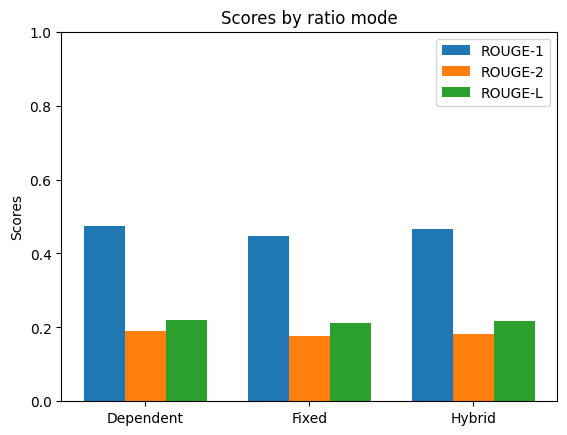

In [5]:
#Plot the Rouge metrics using matplotlib
rouge_1 = ratio_data['ROUGE-1'].values
rouge_2 = ratio_data['ROUGE-2'].values
rouge_l = ratio_data['ROUGE-L'].values


figure, ax = plt.subplots()
bar_labels = ratio_data.index
bar_labels = [x.capitalize() for x in bar_labels]

ratio_data_dict = {
    bar_labels[0]: rouge_1,
    bar_labels[1]: rouge_2,
    bar_labels[2]: rouge_l
}

bar_colors = ['r', 'g', 'b']

x = np.arange(len(bar_labels))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0


for attribute, measurement in ratio_data_dict.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1

ax.set_ylabel('Scores')
ax.set_title('Scores by ratio mode')
ax.set_xticks(x + width, bar_labels)
ax.legend(['ROUGE-1', 'ROUGE-2', 'ROUGE-L'])
ax.set_ylim(0, 1)

plt.show()


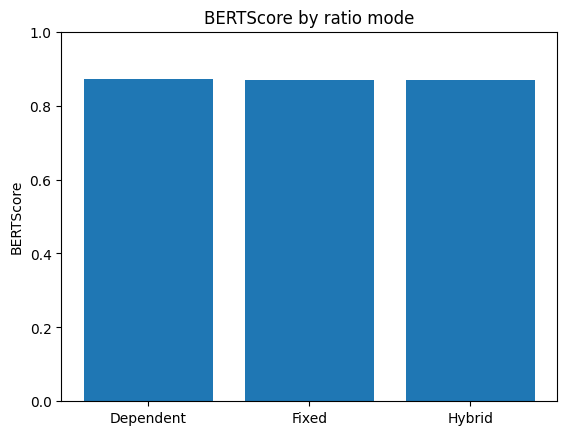

In [6]:
bert_score = ratio_data['BERTScore'].values

figure, ax = plt.subplots()
bar_labels = ratio_data.index
bar_labels = [x.capitalize() for x in bar_labels]

bar_colors = ['r', 'g', 'b']

x = np.arange(len(bar_labels))  # the label locations


rects = ax.bar(x, bert_score, label='BERTScore')

ax.set_ylabel('BERTScore')
ax.set_title('BERTScore by ratio mode')
ax.set_xticks(x, bar_labels)
ax.set_ylim(0, 1)

plt.show()


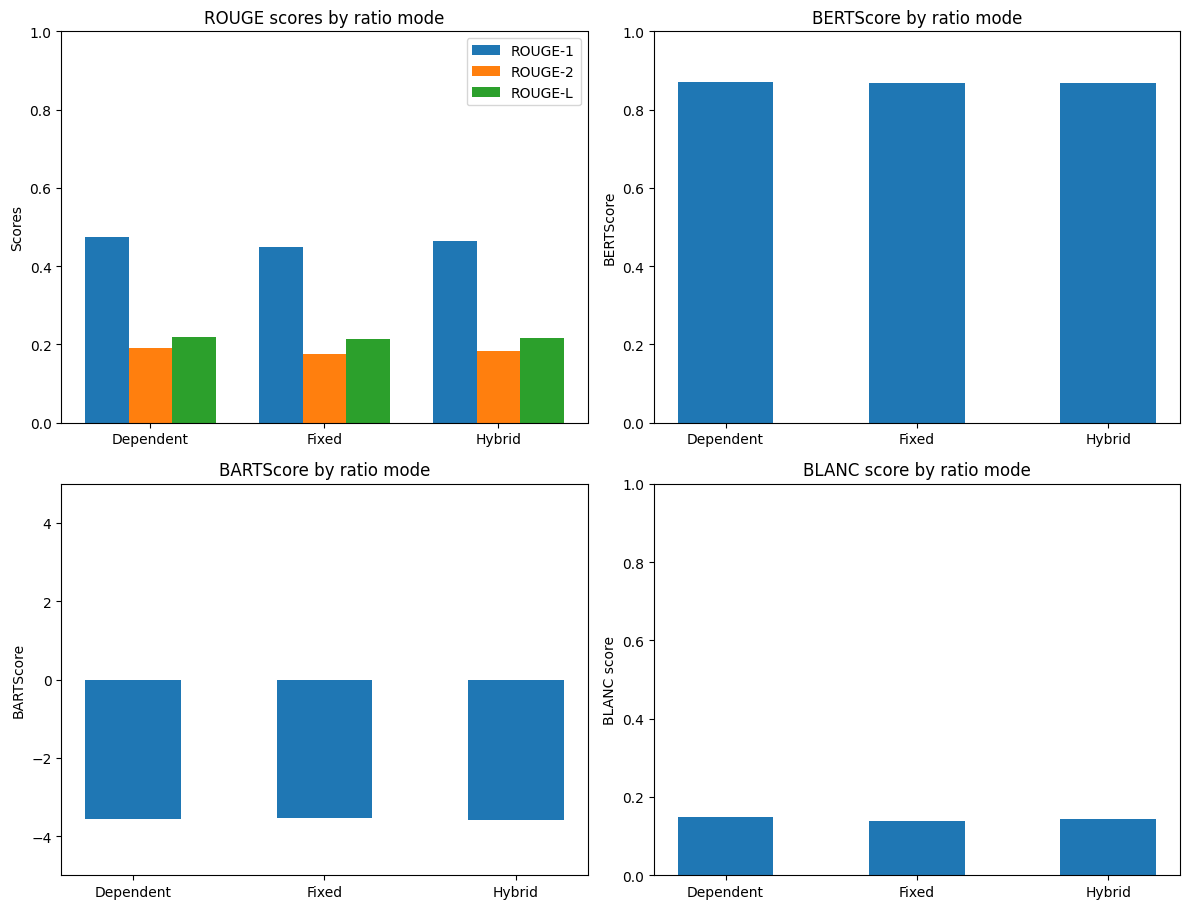

In [7]:
create_one_big_plot(ratio_data, 'ratio mode')

## 3.2: Legal vs Non Legal LMs (extractive)

### 3.2.1: Further process dataset and print latex

In [8]:
#Average results for models that are Legal and Non legal, resulting in two lists with results of the two groups

legal_data = extractive_research_data.groupby(['Legal_model']).mean()
legal_data = legal_data.drop(columns=['Context_length_extractive', 'Context_length_abstractive'])

# Create a copy of legal_data with the index renamed
legal_data_copy = legal_data.rename_axis('Model type').reset_index()


# Convert the modified DataFrame to LaTeX
caption = 'Average evaluation results for Legal LMs and General LMs'
print(create_latex_string(legal_data_copy, caption))

\begin{table}[!h]
\centering
\begin{tabular}{lccccccc}
\toprule
Model type &  ROUGE-1 &  ROUGE-2 &  ROUGE-L &  BERTScore &  BARTScore &  BLANC &   0 \\
\midrule
General LM &   0.4681 &   0.1862 &   0.2180 &     0.8702 &    -3.5664 & 0.1469 & NaN \\
  Legal LM &   0.4568 &   0.1793 &   0.2150 &     0.8688 &    -3.5635 & 0.1413 & NaN \\
\bottomrule
\end{tabular}
\caption{Average evaluation results for Legal LMs and General LMs}
\label{tab: Average evaluation results for Legal LMs and General LMs}
\end{table}



/var/folders/d4/csgbs8kx47vg354l4c66hmvh0000gn/T/ipykernel_60625/2187269539.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  legal_data = extractive_research_data.groupby(['Legal_model']).mean()
/var/folders/d4/csgbs8kx47vg354l4c66hmvh0000gn/T/ipykernel_60625/1413607103.py:93: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_string = data.to_latex(index=False, float_format='%.4f', column_format= column_format, position='!h')


### 3.2.2: Create graphs

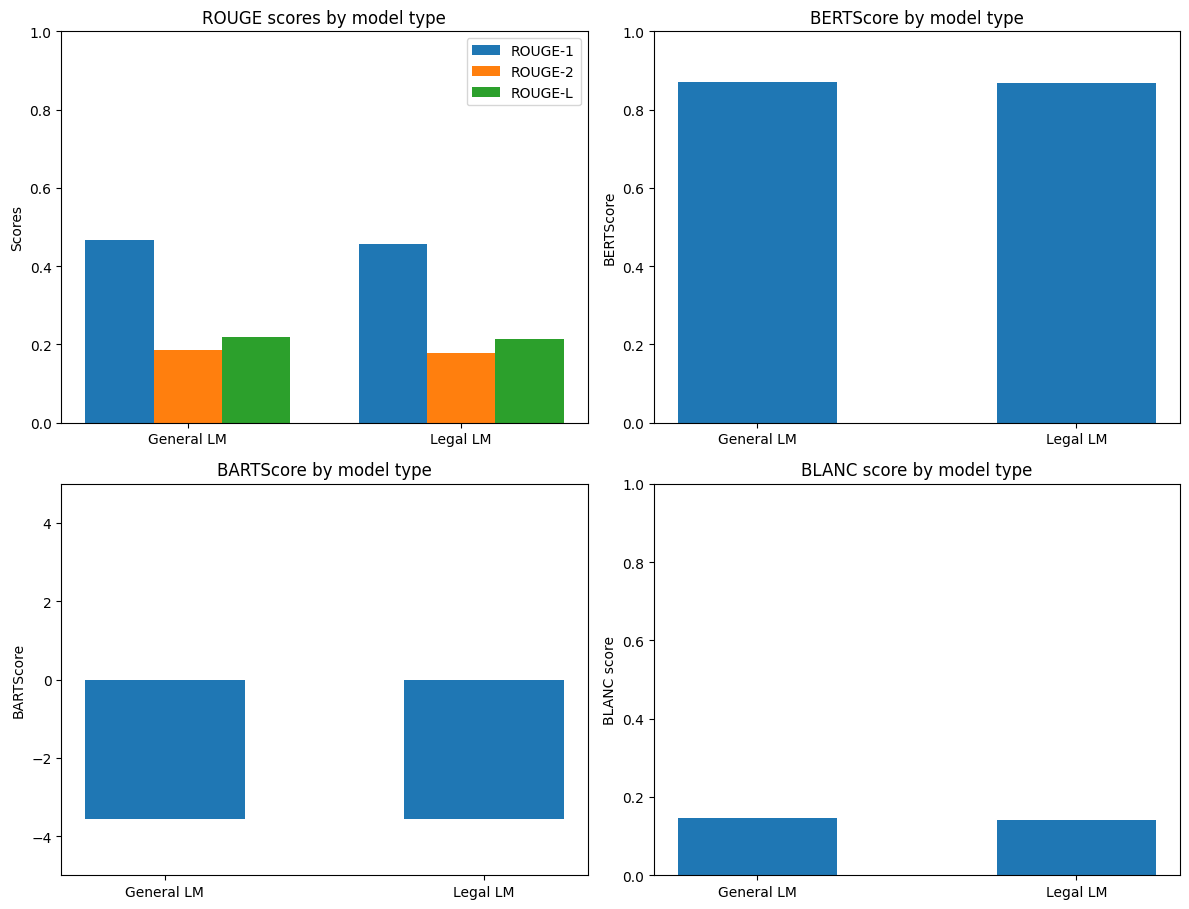

In [9]:
create_one_big_plot(legal_data, 'model type')

## 3.3: Bar graph of Long vs regular context length extractive LMs 

### 3.3.1: Further process dataset and print latex

In [10]:
#Average results for models that have the same context length

extractive_context_length_data = extractive_research_data.groupby(['Context_length_extractive']).mean()
extractive_context_length_data = extractive_context_length_data.drop(columns= ['Context_length_abstractive'])

# Create a copy of extractive_context_length_data with the index renamed
extractive_context_length_data_copy = extractive_context_length_data.rename_axis('Extractive context length').reset_index()


# Convert the modified DataFrame to LaTeX
caption = 'Average evaluation results for models with the same extractive context length'
print(create_latex_string(extractive_context_length_data_copy, caption))

\begin{table}[!h]
\centering
\begin{tabular}{lccccccc}
\toprule
 Extractive context length &  ROUGE-1 &  ROUGE-2 &  ROUGE-L &  BERTScore &  BARTScore &  BLANC &   0 \\
\midrule
                  512.0000 &   0.4643 &   0.1850 &   0.2174 &     0.8696 &    -3.5478 & 0.1468 & NaN \\
                 4096.0000 &   0.4575 &   0.1780 &   0.2145 &     0.8690 &    -3.5930 & 0.1388 & NaN \\
\bottomrule
\end{tabular}
\caption{Average evaluation results for models with the same extractive context length}
\label{tab: Average evaluation results for models with the same extractive context length}
\end{table}



/var/folders/d4/csgbs8kx47vg354l4c66hmvh0000gn/T/ipykernel_60625/4152700239.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  extractive_context_length_data = extractive_research_data.groupby(['Context_length_extractive']).mean()
/var/folders/d4/csgbs8kx47vg354l4c66hmvh0000gn/T/ipykernel_60625/1413607103.py:93: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_string = data.to_latex(index=False, float_format='%.4f', column_format= column_format, position='!h')


### 3.3.2: Create graphs

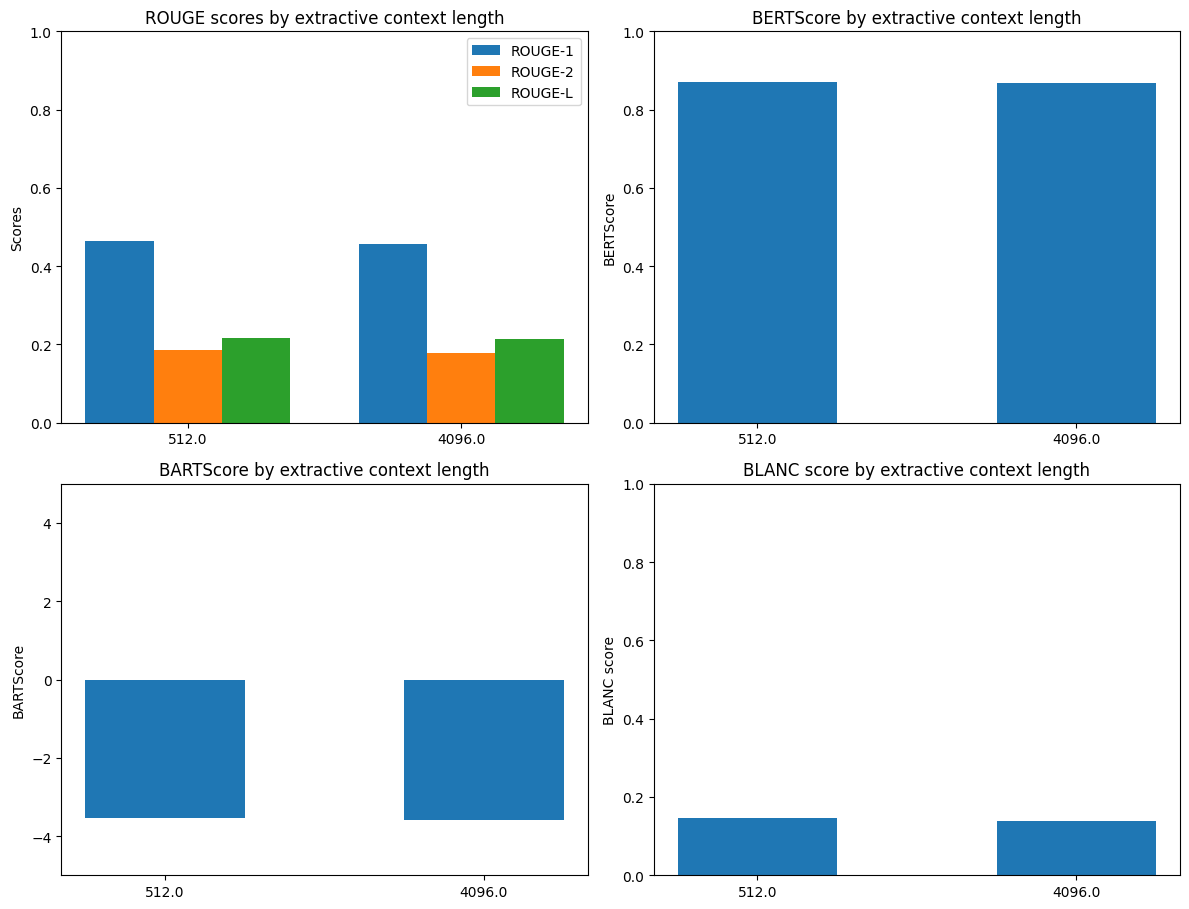

In [11]:
create_one_big_plot(extractive_context_length_data, 'extractive context length')

# Extra: Ranking table

In [12]:

# Create a dictionary to store the top 5 models for each metric
top_5_models = {metric: [] for metric in extractive_research_data.columns[4:10]}
for metric in top_5_models:
    top_5_models[metric] = extractive_research_data.nlargest(5, metric)['Model_ID'].values

# Print the top 5 models for each metric
for metric, models in top_5_models.items():
    print(f'Top 5 models for {metric}: {models}')

Top 5 models for ROUGE-1: ['RoBERTa_BART_dependent_V1' 'LexLM_BART_dependent_V1'
 'RoBERTa_BART_hybrid_V1' 'Longformer_BART_hybrid_V1'
 'LexLM_Longformer_BART_dependent_V1']
Top 5 models for ROUGE-2: ['RoBERTa_BART_dependent_V1' 'LexLM_BART_dependent_V1'
 'BART_no_extraction_V2' 'RoBERTa_BART_hybrid_V1'
 'Longformer_BART_dependent_V1']
Top 5 models for ROUGE-L: ['RoBERTa_BART_dependent_V1' 'LexLM_BART_dependent_V1'
 'Longformer_BART_dependent_V1' 'RoBERTa_BART_hybrid_V1'
 'LexLM_Longformer_BART_hybrid_V1']
Top 5 models for BERTScore: ['RoBERTa_BART_dependent_V1' 'LexLM_BART_dependent_V1'
 'LegalBERT_BART_dependent_V1' 'Longformer_BART_dependent_V1'
 'Longformer_BART_hybrid_V1']
Top 5 models for BARTScore: ['BART_no_extraction_V2' 'LegalBERT_BART_dependent_V1'
 'LegalBERT_BART_fixed_V1' 'LexLM_Longformer_BART_dependent_V1'
 'LegalBERT_BART_hybrid_V1']
Top 5 models for BLANC: ['BART_no_extraction_V2' 'LexLM_BART_dependent_V1'
 'RoBERTa_BART_dependent_V1' 'Longformer_BART_dependent_V1'
 '

In [13]:
print(data.columns)

Index([                  'Model_ID',           'Extractive_model',
                'Abstractive_model',                 'Ratio_mode',
                          'ROUGE-1',                    'ROUGE-2',
                          'ROUGE-L',                  'BERTScore',
                        'BARTScore',                      'BLANC',
                                  0,                'Legal_model',
        'Context_length_extractive', 'Context_length_abstractive'],
      dtype='object')


## 3.4: Long vs regular context length abstractive LMs 

### 3.4.1: Further process dataset and print latex

### 3.4.2: Create graphs

# Extra: Ranking table for abstractive models


In [15]:


# Create a dictionary to store the top 5 models for each metric
top_5_models = {metric: [] for metric in abstractive_research_data.columns[4:10]}
for metric in top_5_models:
    top_5_models[metric] = abstractive_research_data.nlargest(5, metric)['Model_ID'].values

# Print the top 5 models for each metric
for metric, models in top_5_models.items():
    print(f'Top 5 models for {metric}: {models}')

Top 5 models for ROUGE-1: ['Pegasus_no_extraction_V1' 'T5_no_extraction_V1'
 'RoBERTa_T5_dependent_V1' 'PegasusX_no_extraction_V1'
 'RoBERTa_PegasusX_dependent_V1']
Top 5 models for ROUGE-2: ['Pegasus_no_extraction_V1' 'T5_no_extraction_V1'
 'RoBERTa_T5_dependent_V1' 'PegasusX_no_extraction_V1'
 'RoBERTa_PegasusX_dependent_V1']
Top 5 models for ROUGE-L: ['Pegasus_no_extraction_V1' 'T5_no_extraction_V1'
 'RoBERTa_T5_dependent_V1' 'PegasusX_no_extraction_V1'
 'RoBERTa_PegasusX_dependent_V1']
Top 5 models for BERTScore: ['Pegasus_no_extraction_V1' 'T5_no_extraction_V1'
 'RoBERTa_T5_dependent_V1' 'PegasusX_no_extraction_V1'
 'RoBERTa_PegasusX_dependent_V1']
Top 5 models for BARTScore: ['Pegasus_no_extraction_V1' 'T5_no_extraction_V1'
 'RoBERTa_T5_dependent_V1' 'PegasusX_no_extraction_V1'
 'RoBERTa_PegasusX_dependent_V1']
Top 5 models for BLANC: ['Pegasus_no_extraction_V1' 'T5_no_extraction_V1'
 'RoBERTa_T5_dependent_V1' 'PegasusX_no_extraction_V1'
 'RoBERTa_PegasusX_dependent_V1']
